In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Data Exploration

In [2]:
# loading in data
df = pd.read_csv("train.csv")

# df['bid_ask_ratio'] = df['bid_size']/df['ask_size']

df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [3]:
df["target_change"] = np.ones_like(df["target"])

df.loc[df["target"]<0,'target_change'] = -1

df = df.drop(["target","bid_price","ask_price","row_id"], axis=1)

To better understand the data we are working with, we beign by plotting the correlation of each predictor with one another

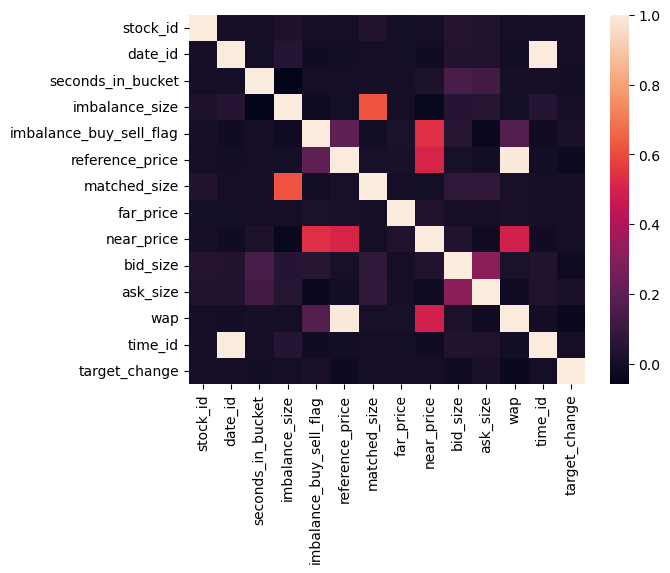

In [4]:
# isolating numerical values
num_vals = df
# starting by removing NaN values from dataset
# we can try some more complex methods later on
num_vals = num_vals.dropna()

# creating heatmap
corr_plot = sns.heatmap(num_vals.corr())

In [5]:
num_vals.corr()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_size,ask_size,wap,time_id,target_change
stock_id,1.000000,0.005824,-0.000090,0.023061,0.004772,0.000348,0.036701,-0.000831,0.004618,0.041245,0.034483,0.000436,0.005824,-0.000330
date_id,0.005824,1.000000,-0.001001,0.045681,-0.010580,-0.007117,0.003408,-0.003004,-0.012255,0.038105,0.030655,-0.007524,1.000000,0.001037
seconds_in_bucket,-0.000090,-0.001001,1.000000,-0.058611,0.002110,0.003402,0.003438,-0.000550,0.023635,0.144290,0.125675,0.003568,-0.000054,-0.007143
imbalance_size,0.023061,0.045681,-0.058611,1.000000,-0.020432,-0.002444,0.622069,0.000523,-0.035491,0.047609,0.049366,-0.001927,0.045625,0.001677
imbalance_buy_sell_flag,0.004772,-0.010580,0.002110,-0.020432,1.000000,0.200544,-0.007488,0.018010,0.537330,0.048959,-0.026707,0.167675,-0.010578,0.014302
reference_price,0.000348,-0.007117,0.003402,-0.002444,0.200544,1.000000,0.010638,0.015349,0.504644,0.008795,-0.005956,0.994275,-0.007114,-0.023758
matched_size,0.036701,0.003408,0.003438,0.622069,-0.007488,0.010638,1.000000,-0.000705,-0.001593,0.072581,0.078511,0.011206,0.003411,0.003729
far_price,-0.000831,-0.003004,-0.000550,0.000523,0.018010,0.015349,-0.000705,1.000000,0.031519,0.002229,-0.000153,0.014643,-0.003005,0.000306
near_price,0.004618,-0.012255,0.023635,-0.035491,0.537330,0.504644,-0.001593,0.031519,1.000000,0.035075,-0.013449,0.492545,-0.012233,-0.000483
bid_size,0.041245,0.038105,0.144290,0.047609,0.048959,0.008795,0.072581,0.002229,0.035075,1.000000,0.306011,0.016921,0.038241,-0.017100


In our plot, we noticed some high correlations betweeen:
- near price & reference price: 0.47
- imbalance_buy_sell_flag & reference price: 0.51
- imbalance size & matched size: 0.51

Looking at the correlation heatmap, it is very obvious that we need to do some feature selection on this data when constructing our models. Also, as expected, Target had no correlations with ANY of the features (otherwise there would be no Kaggle competition to begin with).

To begin with we create a simple linear model using the full feature space to act as our baseline

## Baseline Model

The respone is super tight around 1. Seems like we will need to normalize the data so that we can actually use it for our analysis

In [6]:
# trying a thing
st0 = df[df["stock_id"] == 0]

st0 = st0.drop(["stock_id","time_id","reference_price","far_price","near_price","date_id"], axis = 1)

st0.head()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,matched_size,bid_size,ask_size,wap,target_change
0,0,3180602.69,1,13380276.64,60651.50,8493.03,1.000000,-1.0
191,10,1299772.70,1,15261106.63,13996.50,23519.16,0.999892,1.0
382,20,1299772.70,1,15261106.63,4665.50,12131.60,0.999842,1.0
573,30,1299772.70,1,15261106.63,55998.00,46203.30,1.000085,1.0
764,40,1218204.43,1,15342674.90,14655.95,26610.45,1.000317,1.0


In [7]:
# creating test-train split
X = st0.drop(["target_change"], axis = 1)

# created response variable array
y = st0["target_change"]

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2)

In [8]:
# creating model with fit
lmod = LogisticRegression()
lmod.fit(X_tr,y_tr)

LogisticRegression()

In [9]:
# generating predictions
y_hat = lmod.predict(X_tst)

# finding rmse of the baseline model
baseline_score = accuracy_score(y_tst, y_hat)
print(baseline_score)

0.5205065205065205


In [10]:
confusion_matrix(y_tst, y_hat)

array([[2016,  693],
       [1844,  738]], dtype=int64)

In [11]:
# creating feature selection model
bes = SequentialFeatureSelector(LogisticRegression(), 
                                direction="forward")

# perfoming model fit
bes.fit(X_tr, y_tr)

# printing optimal feat
pred_bet_feature_set = bes.get_feature_names_out()
print(pred_bet_feature_set)

['seconds_in_bucket' 'imbalance_size' 'imbalance_buy_sell_flag']


In [12]:
X_tr = X_tr[pred_bet_feature_set]
X_tst = X_tst[pred_bet_feature_set]

lmod = LogisticRegression()

lmod.fit(X_tr,y_tr)

lmod_preds = lmod.predict(X_tst)

# rmse with removed features
acc_subset = accuracy_score(y_tst, y_hat)
print(acc_subset)

0.5205065205065205


Looking at the RMSE we see above, it appears as though removing these features does not cause any significant increase in the RMSE. Although based on earlier correlation plots, it seems as though more features can be removed from the data.